In [2]:
import numpy as np
from numpy.linalg import norm
from numpy.random import normal, uniform
import matplotlib.pyplot as plt
from time import clock

class Potential:
    """ Represents a potential function. """
    def __init__(self, potential="gaussian", dimension=1):
        self.dim = dimension
        self.name = potential
        # To add a potential, add it to the dictionary below and implement it/its gradient.
        self.function, self.gradient, self.gradient2, self.vector_lap_grad = {
            "gaussian":         (self.gaussian,         self.gaussian_grad,         None, None),
            "double_well":      (self.double_well,      self.double_well_grad,      self.double_well_grad2, self.double_well_vector_lap_grad),
            "Ginzburg_Landau":  (self.Ginzburg_Landau,  self.Ginzburg_Landau_grad,  None, None)
        }[potential]

        # Quantities to store in the Potential class, to avoid needless re-computation.
        self.inv_sigma = 1. / np.arange(1, dimension+1, dtype=float) # for Gaussian

    def gaussian(self, x):
        return 0.5 * np.dot(x, np.multiply(self.inv_sigma, x))

    def gaussian_grad(self, x):
        return np.multiply(self.inv_sigma, x)

    def double_well(self, x):
        normx = norm(x)
        return 0.25 * normx**4 - 0.5 * normx**2

    def double_well_grad(self, x):
        return (norm(x)**2 - 1) * x

    def double_well_grad2(self, x):
        mx = np.matrix(x)
        return (norm(x)**2 - 1) * np.identity(self.dim) + 2 * np.transpose(mx) * mx

    def double_well_vector_lap_grad(self, x):
        return 6*x

    def Ginzburg_Landau(self, x, tau=2.0, lamb=0.5, alpha=0.1):
        d_ = round(self.dim ** (1./3))
        x = np.reshape(x, (d_,d_,d_))
        nabla_tilde = sum( norm(np.roll(x, -1, axis=a) - x)**2 for a in [0,1,2] )
        return 0.5 * (1. - tau) * norm(x)**2 + \
               0.5 * tau * alpha * nabla_tilde + \
               0.25 * tau * lamb * np.sum(np.power(x, 4))

    def Ginzburg_Landau_grad(self, x, tau=2.0, lamb=0.5, alpha=0.1):
        d_ = round(self.dim ** (1./3))
        x = np.reshape(x, (d_,d_,d_))
        temp = sum( np.roll(x, sgn, axis=a) for sgn in [-1,1] for a in [0,1,2] )
        return ((1. - tau) * x + \
                tau * lamb * np.power(x, 3) + \
                tau * alpha * (6*x - temp)).flatten()

class Evaluator:
    """ Evaluates a set of Langevin algorithms on given potentials. """
    def __init__(self, potential="gaussian", dimension=1, N=10**2, burn_in=10**2, N_sim=5, x0=[0], step=0.01, timer=None):
        self.dim = dimension
        # To add an algorithm, add it to the dictionary below and implement it as a class method.
        self.algorithms = {
            "ULA":     self.ULA,
            "tULA":    self.tULA,
            "tULAc":   self.tULAc,
            "MALA":    self.MALA,
            "RWM":     self.RWM,
            "tMALA":   self.tMALA,
            "tMALAc":  self.tMALAc,
            "tHOLA":   self.tHOLA,
            "LM":      self.LM,
            "tLM":     self.tLM,
            "tLMc":    self.tLMc
        }
        self.N = N
        self.burn_in = burn_in
        self.N_sim = N_sim
        self.x0 = x0
        self.step = step
        self.timer = timer
        if timer:
            self.N = 10**10 # ~~practically infinity
            self.start_time = clock()
        self.potential = Potential(potential, dimension)
        # invoked by self.potential.funtion(parameters), self.potential.gradient(parameters)

    def ULA(self):
        x = np.array(self.x0)
        m1, m2 = np.zeros(self.dim, dtype=float), np.zeros(self.dim, dtype=float)
        sqrtstep = np.sqrt(2*self.step)

        for i in range(self.burn_in + self.N):
            if self.timer and clock() - self.start_time > self.timer:
                break

            if i >= self.burn_in:
                m1 += x
                m2 += np.power(x, 2)
            x += -self.step * self.potential.gradient(x) + sqrtstep * normal(size=self.dim)
        return m1, m2/float(i+1-self.burn_in), i+1 #i+1 = no. of iterations

    def tULA(self, taming=(lambda g, step: g/(1. + step*norm(g)))):
        x = np.array(self.x0)
        m1, m2 = np.zeros(self.dim, dtype=float), np.zeros(self.dim, dtype=float)
        sqrtstep = np.sqrt(2*self.step)

        for i in range(self.burn_in + self.N):
            if self.timer and clock() - self.start_time > self.timer:
                break

            if i >= self.burn_in:
                m1 += x
                m2 += np.power(x, 2)
            x += -self.step * taming(self.potential.gradient(x), self.step) + sqrtstep * normal(size=self.dim)
        return m1, m2/float(i+1-self.burn_in), i+1 #i+1 = no. of iterations

    def tULAc(self):
        # coordinate-wise taming function
        return self.tULA(lambda g, step: np.divide(g, 1. + step*np.absolute(g)))

    def MALA(self):
        acc = 0 # acceptance probability
        m1, m2 = np.zeros(self.dim, dtype=float), np.zeros(self.dim, dtype=float)
        x = np.array(self.x0)

        for i in range(self.burn_in + self.N):
            if self.timer and clock() - self.start_time > self.timer:
                break

            if i >= self.burn_in:
                m1 += x
                m2 += np.power(x, 2)
            U_x, grad_U_x = self.potential.function(x), self.potential.gradient(x)
            y = x - self.step * grad_U_x + np.sqrt(2 * self.step) * normal(size=self.dim)
            U_y, grad_U_y = self.potential.function(y), self.potential.gradient(y)

            logratio = -U_y + U_x + 1./(4*self.step) * (norm(y - x + self.step*grad_U_x)**2 \
                       -norm(x - y + self.step*grad_U_y)**2)
            if np.log(uniform(size = 1)) <= logratio:
                x = y
                if i >= self.burn_in:
                    acc += 1

        return m1, m2/float(i+1-self.burn_in), i+1, acc/float(i+1) #i+1 = no. of iterations

    def RWM(self):
        acc = 0 # acceptance probability
        m1, m2 = np.zeros(self.dim, dtype=float), np.zeros(self.dim, dtype=float)
        x = np.array(self.x0)

        for i in range(self.burn_in + self.N):
            if self.timer and clock() - self.start_time > self.timer:
                break

            if i >= self.burn_in:
                m1 += x
                m2 += np.power(x, 2)
            y = x + np.sqrt(2*self.step) * normal(self.dim)
            logratio = self.potential.function(x) - self.potential.function(y)
            if np.log(uniform(size = 1)) <= logratio:
                x = y
                if i >= self.burn_in:
                    acc += 1

        return m1, m2/float(i+1-self.burn_in), i+1, acc/float(i+1) #i+1 = no. of iterations


    def tMALA(self, taming=(lambda g, step: g/(1. + step*norm(g)))):
        acc = 0 # acceptance probability
        m1, m2 = np.zeros(self.dim, dtype=float), np.zeros(self.dim, dtype=float)
        x = np.array(self.x0)

        for i in range(self.burn_in + self.N):
            if self.timer and clock() - self.start_time > self.timer:
                break

            if i >= self.burn_in:
                m1 += x
                m2 += np.power(x, 2)
            U_x, grad_U_x = self.potential.function(x), self.potential.gradient(x)
            tamed_gUx = taming(grad_U_x, self.step)
            y = x - self.step * tamed_gUx + np.sqrt(2*self.step) * normal(size=self.dim)
            U_y, grad_U_y = self.potential.function(y), self.potential.gradient(y)
            tamed_gUy = taming(grad_U_y, self.step)

            logratio = -U_y + U_x + 1./(4*self.step) * (norm(y - x + self.step*tamed_gUx)**2 - norm(x - y + self.step*tamed_gUy)**2)
            if np.log(uniform(size = 1)) <= logratio:
                x = y
                if i >= self.burn_in:
                    acc += 1

        return m1, m2/float(i+1-self.burn_in), i+1, acc/float(i+1) #i+1 = no. of iterations

    def tMALAc(self):
        return self.tMALA(lambda g, step: np.divide(g, 1. + step * np.absolute(g)))

    def tHOLA(self):
        m1, m2 = np.zeros(self.dim, dtype=float), np.zeros(self.dim, dtype=float)
        x = np.array(self.x0)

        for i in range(self.burn_in + self.N):
            if self.timer and clock() - self.start_time > self.timer:
                break

            if i >= self.burn_in:
                m1 += x
                m2 += np.power(x, 2)

            norm_x = norm(x)
            grad_U = self.potential.gradient(x)
            norm_grad_U = norm(grad_U)
            grad_U_gamma = grad_U / (1 + (self.step * norm_grad_U)**1.5)**(2./3)
            grad2_U = self.potential.gradient2(x)
            norm_grad2_U = norm(grad2_U)
            grad2_U_gamma = grad2_U / (1 + self.step * norm_grad2_U)

            laplacian_grad_U = self.potential.vector_lap_grad(x)
            laplacian_grad_U_gamma = laplacian_grad_U / (1 + self.step**0.5 * norm_x * norm(laplacian_grad_U))

            grad2_U_grad_U_gamma = np.matmul(grad2_U, grad_U).A1 / (1 + self.step * norm_x * norm_grad2_U * norm_grad_U)

            x += -self.step * grad_U_gamma + 0.5 * self.step**2 * (grad2_U_grad_U_gamma - laplacian_grad_U_gamma) + \
                  np.sqrt(2*self.step) * normal(size=self.dim) - np.sqrt(2) * np.matmul(grad2_U_gamma, normal(size=self.dim)).A1 * np.sqrt(self.step**3/3)

        return m1, m2/float(i+1-self.burn_in), i+1 #i+1 = no. of iterations

    def LM(self):
        x = np.array(self.x0)
        m1, m2 = np.zeros(self.dim, dtype=float), np.zeros(self.dim, dtype=float)
        sqrtstep = np.sqrt(0.5 * self.step)
        gaussian = normal(size=self.dim)

        for i in range(self.burn_in + self.N):
            if self.timer and clock() - self.start_time > self.timer:
                break

            if i >= self.burn_in:
                m1 += x
                m2 += np.power(x, 2)
            gaussian_plus1 = normal(size=self.dim)
            x += -self.step * self.potential.gradient(x) + sqrtstep * (gaussian + gaussian_plus1) * 0.5
            gaussian = gaussian_plus1
        return m1, m2/float(i+1-self.burn_in), i+1 #i+1 = no. of iterations

    def tLM(self, taming=(lambda g, step: g/(1. + step * norm(g)))):
        x = np.array(self.x0)
        m1, m2 = np.zeros(self.dim, dtype=float), np.zeros(self.dim, dtype=float)
        sqrtstep = np.sqrt(0.5 * self.step)
        gaussian = normal(size=self.dim)

        for i in range(self.burn_in + self.N):
            if self.timer and clock() - self.start_time > self.timer:
                break

            if i >= self.burn_in:
                m1 += x
                m2 += np.power(x, 2)
            gaussian_plus1 = normal(size=self.dim)
            x += -self.step * taming(self.potential.gradient(x), self.step) + sqrtstep * (gaussian + gaussian_plus1) * 0.5
            gaussian = gaussian_plus1
        return m1, m2/float(i+1-self.burn_in), i+1 #i+1 = no. of iterations

    def tLMc(self):
        return self.tLM(lambda g, step: np.divide(g, 1. + step * np.absolute(g)))

    def sampler(self, algorithm="ULA"):
        if self.timer:
            self.start_time = clock()
        return self.algorithms[algorithm]()

    def analysis(self, algorithm="ULA"):
        print(f'\n######### Algorithm: {algorithm}')
        print(f'Dimension: {self.dim}\nN: {self.N}\nBurn in: {self.burn_in}\nNumber of simulations: {self.N_sim}\nStep: {self.step}\nTimer: {self.timer}s\nx0[0]: {self.x0[0]}')
        print('#################\n')

        moment1, moment2, acceptances = [], [], []
        for _ in range(self.N_sim):
            m1, m2, iterations, *acc = self.sampler(algorithm)
            if self.potential.name in ['double_well', 'Ginzburg_Landau']:
                if norm(m1, np.inf) > 10:
                    m1 = np.nan * m1
                if norm(m2, np.inf) > 10:
                    m2 = np.nan * m2
            print(f'Run of {algorithm} finished, with {iterations} iterations. m1[0], m2[0], acc = {m1[0], m2[0], acc}')
            moment1.append(m1)
            moment2.append(m2)
            if acc:
                acceptances.append(acc[0])
        return moment1, moment2, acceptances



# TODO: RWM is buggy

potential = 'gaussian'
d = 2
N = 100
burn_in = 1 #10**4
N_sim = 5
x0 = np.array([1] + [1]*(d-1), dtype=float)
step = 0.01

# TIMER MODE: number of seconds which we allow the algorithms to run
# To run normally without a timer, omit the last parameter
timer = 1
e = Evaluator(potential, dimension=d, N=N, burn_in=burn_in, N_sim=N_sim, x0=x0, step=step, timer=timer)

algorithms = ['ULA']#'tULA', 'tULAc', 'MALA', 'tMALA', 'tMALAc', 'LM', 'tLM', 'tLMc']

# First moments. for Gaussian, we take norm, for well and Ginzburg, we take the first coordinate
data = [[norm(p) if potential=='gaussian' else p[0] for p in e.analysis(algo)[0]] for algo in algorithms]

#plt.plot(data)
# Boxplots
#plt.title(f'Potential: {potential.upper()}\nDim={d}, {"Timer" if e.timer else "N"}={timer if e.timer else N}\nburn_in={burn_in}, N_sim={N_sim}, step={step}, x0[0]={x0[0]}')
#plt.boxplot(data, labels=algorithms)
#plt.show()

C:\Users\s1415551\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:84: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
C:\Users\s1415551\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:269: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
C:\Users\s1415551\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:94: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead



######### Algorithm: ULA
Dimension: 2
N: 10000000000
Burn in: 1
Number of simulations: 5
Step: 0.01
Timer: 1s
x0[0]: 1.0
#################

Run of ULA finished, with 49142 iterations. m1[0], m2[0], acc = (-365.69099947504515, 0.8959876142832808, [])
Run of ULA finished, with 40873 iterations. m1[0], m2[0], acc = (-5513.7242370460635, 1.054474955523816, [])
Run of ULA finished, with 36523 iterations. m1[0], m2[0], acc = (7352.21384469625, 1.0957656300192908, [])
Run of ULA finished, with 44917 iterations. m1[0], m2[0], acc = (-1663.3256249196331, 1.035852802527871, [])
Run of ULA finished, with 35667 iterations. m1[0], m2[0], acc = (-1193.823600643445, 0.9416679652558719, [])


In [54]:
import numpy as np
from numpy.linalg import norm
from numpy.random import normal, uniform
import matplotlib.pyplot as plt
from time import clock

class Potential:
    """ Represents a potential function. """
    def __init__(self, potential="gaussian", dimension=1):
        self.dim = dimension
        self.name = potential
        # To add a potential, add it to the dictionary below and implement it/its gradient.
        self.function, self.gradient, self.gradient2, self.vector_lap_grad = {
            "gaussian":         (self.gaussian,         self.gaussian_grad,         None, None),
            "double_well":      (self.double_well,      self.double_well_grad,      self.double_well_grad2, self.double_well_vector_lap_grad),
            "Ginzburg_Landau":  (self.Ginzburg_Landau,  self.Ginzburg_Landau_grad,  None, None)
        }[potential]

        # Quantities to store in the Potential class, to avoid needless re-computation.
        self.inv_sigma = 1. / np.arange(1, dimension+1, dtype=float) # for Gaussian

    def gaussian(self, x):
        return 0.5 * np.dot(x, np.multiply(self.inv_sigma, x))

    def gaussian_grad(self, x):
        return np.multiply(self.inv_sigma, x)

    def double_well(self, x):
        normx = norm(x)
        return 0.25 * normx**4 - 0.5 * normx**2

    def double_well_grad(self, x):
        return (norm(x)**2 - 1) * x

    def double_well_grad2(self, x):
        mx = np.matrix(x)
        return (norm(x)**2 - 1) * np.identity(self.dim) + 2 * np.transpose(mx) * mx

    def double_well_vector_lap_grad(self, x):
        return 6*x

    def Ginzburg_Landau(self, x, tau=2.0, lamb=0.5, alpha=0.1):
        d_ = round(self.dim ** (1./3))
        x = np.reshape(x, (d_,d_,d_))
        nabla_tilde = sum( norm(np.roll(x, -1, axis=a) - x)**2 for a in [0,1,2] )
        return 0.5 * (1. - tau) * norm(x)**2 + \
               0.5 * tau * alpha * nabla_tilde + \
               0.25 * tau * lamb * np.sum(np.power(x, 4))

    def Ginzburg_Landau_grad(self, x, tau=2.0, lamb=0.5, alpha=0.1):
        d_ = round(self.dim ** (1./3))
        x = np.reshape(x, (d_,d_,d_))
        temp = sum( np.roll(x, sgn, axis=a) for sgn in [-1,1] for a in [0,1,2] )
        return ((1. - tau) * x + \
                tau * lamb * np.power(x, 3) + \
                tau * alpha * (6*x - temp)).flatten()

class Evaluator:
    """ Evaluates a set of Langevin algorithms on given potentials. """
    def __init__(self, potential="gaussian", dimension=1, N=10**2, burn_in=10**2, N_sim=5, x0=[0], step=0.01, timer=None):
        self.dim = dimension
        # To add an algorithm, add it to the dictionary below and implement it as a class method.
        self.algorithms = {
            "MALA":    self.MALA,
            "RWM":     self.RWM,
        }
        self.N = N
        self.burn_in = burn_in
        self.N_sim = N_sim
        self.x0 = x0
        self.step = step
        self.timer = timer
        if timer:
            self.N = 10**10 # ~~practically infinity
            self.start_time = clock()
        self.potential = Potential(potential, dimension)
        # invoked by self.potential.funtion(parameters), self.potential.gradient(parameters)
    def MALA(self):
        acc = 0 # acceptance probability
        m1 = np.zeros([self.N,self.dim], dtype=float)
        x = np.array(self.x0)

        for i in range(self.burn_in + self.N):
            if self.timer and clock() - self.start_time > self.timer:
                break

            if i >= self.burn_in:
                m1=np.append(m1, x)
                np.reshape(m1, [i,self.dim])
            U_x, grad_U_x = self.potential.function(x), self.potential.gradient(x)
            y = x - self.step * grad_U_x + np.sqrt(2 * self.step) * normal(size=self.dim)
            U_y, grad_U_y = self.potential.function(y), self.potential.gradient(y)

            logratio = -U_y + U_x + 1./(4*self.step) * (norm(y - x + self.step*grad_U_x)**2 \
                       -norm(x - y + self.step*grad_U_y)**2)
            if np.log(uniform(size = 1)) <= logratio:
                x = y
                if i >= self.burn_in:
                    acc += 1

        return m1, i+1, acc/float(i+1) #i+1 = no. of iterations

    def RWM(self):
        acc = 0 # acceptance probability
        m1 = np.zeros([self.N,self.dim], dtype=float)

        x = np.array(self.x0)

        for i in range(self.burn_in + self.N):
            if self.timer and clock() - self.start_time > self.timer:
                break

            if i >= self.burn_in:
                m1=np.append(m1, x)
                np.reshape(m1, [i,self.dim])
            y = x + np.sqrt(2*self.step) * normal(self.dim)
            logratio = self.potential.function(x) - self.potential.function(y)
            if np.log(uniform(size = 1)) <= logratio:
                x = y
                if i >= self.burn_in:
                    acc += 1

        return m1, i+1, acc/float(i+1) #i+1 = no. of iterations


    def sampler(self, algorithm="RWM"):
        if self.timer:
            self.start_time = clock()
        return self.algorithms[algorithm]()

    def analysis(self, algorithm="RWM"):
        print(f'\n######### Algorithm: {algorithm}')
        print(f'Dimension: {self.dim}\nN: {self.N}\nBurn in: {self.burn_in}\nNumber of simulations: {self.N_sim}\nStep: {self.step}\nTimer: {self.timer}s\nx0[0]: {self.x0[0]}')
        print('#################\n')

        moment1, moment2, acceptances = [], [], []
        for _ in range(self.N_sim):
            m1, iterations, *acc = self.sampler(algorithm)
            if self.potential.name in ['double_well', 'Ginzburg_Landau']:
                if norm(m1, np.inf) > 10:
                    m1 = np.nan * m1
            print(f'Run of {algorithm} finished, with {iterations} iterations., m1[0], acc = {m1[0], acc}')
            moment1.append(m1)
            if acc:
                acceptances.append(acc[0])
        return moment1, moment2, acceptances



# TODO: RWM is buggy

potential = 'gaussian'
d = 2
N = 100
burn_in = 1 #10**4
N_sim = 1
x0 = np.array([1] + [1]*(d-1), dtype=float)
step = 0.01

# TIMER MODE: number of seconds which we allow the algorithms to run
# To run normally without a timer, omit the last parameter
timer = 1
e = Evaluator(potential, dimension=d, N=N, burn_in=burn_in, N_sim=N_sim, x0=x0, step=step, timer=timer)

algorithms = [ 'MALA', 'RWM']

# First moments. for Gaussian, we take norm, for well and Ginzburg, we take the first coordinate
data = [[norm(p) if potential=='gaussian' else p[0] for p in e.analysis(algo)[0]] for algo in algorithms]


#plt.show()


######### Algorithm: MALA
Dimension: 2
N: 10000000000
Burn in: 1
Number of simulations: 1
Step: 0.01
Timer: 1s
x0[0]: 1.0
#################



C:\Users\s1415551\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:75: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
C:\Users\s1415551\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:128: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


MemoryError: 

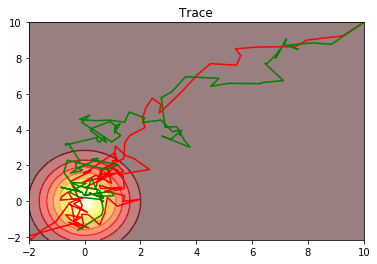

In [86]:
import numpy as np
from numpy.linalg import norm
from numpy.random import normal, uniform
import matplotlib.pyplot as plt
from time import clock

class Potential:
    """ Represents a potential function. """
    def __init__(self, potential="gaussian", dimension=1):
        self.dim = dimension
        self.name = potential
        # To add a potential, add it to the dictionary below and implement it/its gradient.
        self.function, self.gradient, self.gradient2, self.vector_lap_grad = {
            "gaussian":         (self.gaussian,         self.gaussian_grad,         None, None),
            "double_well":      (self.double_well,      self.double_well_grad,      self.double_well_grad2, self.double_well_vector_lap_grad),
            "Ginzburg_Landau":  (self.Ginzburg_Landau,  self.Ginzburg_Landau_grad,  None, None)
        }[potential]

        # Quantities to store in the Potential class, to avoid needless re-computation.
        self.inv_sigma = 1. / np.arange(1, dimension+1, dtype=float) # for Gaussian

    def gaussian(self, x):
        return 0.5 * np.dot(x, np.multiply(self.inv_sigma, x))

    def gaussian_grad(self, x):
        return np.multiply(self.inv_sigma, x)

    def double_well(self, x):
        normx = norm(x)
        return 0.25 * normx**4 - 0.5 * normx**2

    def double_well_grad(self, x):
        return (norm(x)**2 - 1) * x

    def double_well_grad2(self, x):
        mx = np.matrix(x)
        return (norm(x)**2 - 1) * np.identity(self.dim) + 2 * np.transpose(mx) * mx

    def double_well_vector_lap_grad(self, x):
        return 6*x

    def Ginzburg_Landau(self, x, tau=2.0, lamb=0.5, alpha=0.1):
        d_ = round(self.dim ** (1./3))
        x = np.reshape(x, (d_,d_,d_))
        nabla_tilde = sum( norm(np.roll(x, -1, axis=a) - x)**2 for a in [0,1,2] )
        return 0.5 * (1. - tau) * norm(x)**2 + \
               0.5 * tau * alpha * nabla_tilde + \
               0.25 * tau * lamb * np.sum(np.power(x, 4))

    def Ginzburg_Landau_grad(self, x, tau=2.0, lamb=0.5, alpha=0.1):
        d_ = round(self.dim ** (1./3))
        x = np.reshape(x, (d_,d_,d_))
        temp = sum( np.roll(x, sgn, axis=a) for sgn in [-1,1] for a in [0,1,2] )
        return ((1. - tau) * x + \
                tau * lamb * np.power(x, 3) + \
                tau * alpha * (6*x - temp)).flatten()

class Evaluator:
    """ Evaluates a set of Langevin algorithms on given potentials. """
    def __init__(self, potential="gaussian", dimension=1, N=10**2, burn_in=10**2, N_sim=5, x0=[0], step=0.01, timer=None):
        self.dim = dimension
        # To add an algorithm, add it to the dictionary below and implement it as a class method.
        self.algorithms = {
            "ULA":     self.ULA,
            "tULA":    self.tULA,
            "tULAc":   self.tULAc,
            "MALA":    self.MALA,
            "RWM":     self.RWM,
            "tMALA":   self.tMALA,
            "tMALAc":  self.tMALAc,
            "tHOLA":   self.tHOLA,
            "LM":      self.LM,
            "tLM":     self.tLM,
            "tLMc":    self.tLMc
        }
        self.N = N
        self.burn_in = burn_in
        self.N_sim = N_sim
        self.x0 = x0
        self.step = step
        self.timer = timer
        if timer:
            self.N = 10**10 # ~~practically infinity
            self.start_time = clock()
        self.potential = Potential(potential, dimension)
        # invoked by self.potential.funtion(parameters), self.potential.gradient(parameters)
    def ULA(self):
        x = np.array(self.x0)
        sample = np.zeros((self.dim, self.N + self.burn_in), dtype=float)
        sqrtstep = np.sqrt(2*self.step)

        for i in range(self.burn_in + self.N):
            if self.timer and clock() - self.start_time > self.timer:
                break
            sample[:,i]=x
            x += -self.step * self.potential.gradient(x) + sqrtstep * normal(size=self.dim)

        return sample #i+1 = no. of iterations

    def tULA(self, taming=(lambda g, step: g/(1. + step*norm(g)))):
        x = np.array(self.x0)
        sample = np.zeros((self.dim, self.N + self.burn_in), dtype=float)
        sqrtstep = np.sqrt(2*self.step)

        for i in range(self.burn_in + self.N):
            if self.timer and clock() - self.start_time > self.timer:
                break

            sample[:,i]=x
            x += -self.step * taming(self.potential.gradient(x), self.step) + sqrtstep * normal(size=self.dim)
        return sample

    def tULAc(self):
        # coordinate-wise taming function
        return self.tULA(lambda g, step: np.divide(g, 1. + step*np.absolute(g)))

    def MALA(self):
        acc = 0 # acceptance probability
        sample = np.zeros((self.dim, self.N + self.burn_in), dtype=float)
        x = np.array(self.x0)

        for i in range(self.burn_in + self.N):
            if self.timer and clock() - self.start_time > self.timer:
                break

            sample[:,i]=x
            U_x, grad_U_x = self.potential.function(x), self.potential.gradient(x)
            y = x - self.step * grad_U_x + np.sqrt(2 * self.step) * normal(size=self.dim)
            U_y, grad_U_y = self.potential.function(y), self.potential.gradient(y)

            logratio = -U_y + U_x + 1./(4*self.step) * (norm(y - x + self.step*grad_U_x)**2 \
                       -norm(x - y + self.step*grad_U_y)**2)
            if np.log(uniform(size = 1)) <= logratio:
                x = y
                if i >= self.burn_in:
                    acc += 1

        return sample

    def RWM(self):
        acc = 0 # acceptance probability
        sample = np.zeros((self.dim, self.N + self.burn_in), dtype=float)
        x = np.array(self.x0)

        for i in range(self.burn_in + self.N):
            if self.timer and clock() - self.start_time > self.timer:
                break

            sample[:,i]=x
            y = x + np.sqrt(2*self.step) * normal(self.dim)
            logratio = self.potential.function(x) - self.potential.function(y)
            if np.log(uniform(size = 1)) <= logratio:
                x = y
                if i >= self.burn_in:
                    acc += 1

        return sample


    def tMALA(self, taming=(lambda g, step: g/(1. + step*norm(g)))):
        acc = 0 # acceptance probability
        sample = np.zeros((self.dim, self.N + self.burn_in), dtype=float)
        x = np.array(self.x0)

        for i in range(self.burn_in + self.N):
            if self.timer and clock() - self.start_time > self.timer:
                break

            sample[:,i]=x
            U_x, grad_U_x = self.potential.function(x), self.potential.gradient(x)
            tamed_gUx = taming(grad_U_x, self.step)
            y = x - self.step * tamed_gUx + np.sqrt(2*self.step) * normal(size=self.dim)
            U_y, grad_U_y = self.potential.function(y), self.potential.gradient(y)
            tamed_gUy = taming(grad_U_y, self.step)

            logratio = -U_y + U_x + 1./(4*self.step) * (norm(y - x + self.step*tamed_gUx)**2 - norm(x - y + self.step*tamed_gUy)**2)
            if np.log(uniform(size = 1)) <= logratio:
                x = y
                if i >= self.burn_in:
                    acc += 1

        return sample

    def tMALAc(self):
        return self.tMALA(lambda g, step: np.divide(g, 1. + step * np.absolute(g)))

    def tHOLA(self):
        sample = np.zeros((self.dim, self.N + self.burn_in), dtype=float)
        x = np.array(self.x0)

        for i in range(self.burn_in + self.N):
            if self.timer and clock() - self.start_time > self.timer:
                break

            sample[:,i]=x
            norm_x = norm(x)
            grad_U = self.potential.gradient(x)
            norm_grad_U = norm(grad_U)
            grad_U_gamma = grad_U / (1 + (self.step * norm_grad_U)**1.5)**(2./3)
            grad2_U = self.potential.gradient2(x)
            norm_grad2_U = norm(grad2_U)
            grad2_U_gamma = grad2_U / (1 + self.step * norm_grad2_U)

            laplacian_grad_U = self.potential.vector_lap_grad(x)
            laplacian_grad_U_gamma = laplacian_grad_U / (1 + self.step**0.5 * norm_x * norm(laplacian_grad_U))

            grad2_U_grad_U_gamma = np.matmul(grad2_U, grad_U).A1 / (1 + self.step * norm_x * norm_grad2_U * norm_grad_U)

            x += -self.step * grad_U_gamma + 0.5 * self.step**2 * (grad2_U_grad_U_gamma - laplacian_grad_U_gamma) + \
                  np.sqrt(2*self.step) * normal(size=self.dim) - np.sqrt(2) * np.matmul(grad2_U_gamma, normal(size=self.dim)).A1 * np.sqrt(self.step**3/3)

        return sample

    def LM(self):
        x = np.array(self.x0)
        sample = np.zeros((self.dim, self.N + self.burn_in), dtype=float)
        sqrtstep = np.sqrt(0.5 * self.step)
        gaussian = normal(size=self.dim)

        for i in range(self.burn_in + self.N):
            if self.timer and clock() - self.start_time > self.timer:
                break

            sample[:,i]=x
            gaussian_plus1 = normal(size=self.dim)
            x += -self.step * self.potential.gradient(x) + sqrtstep * (gaussian + gaussian_plus1) * 0.5
            gaussian = gaussian_plus1
        return sample

    def tLM(self, taming=(lambda g, step: g/(1. + step * norm(g)))):
        x = np.array(self.x0)
        sample = np.zeros((self.dim, self.N + self.burn_in), dtype=float)
        sqrtstep = np.sqrt(0.5 * self.step)
        gaussian = normal(size=self.dim)

        for i in range(self.burn_in + self.N):
            if self.timer and clock() - self.start_time > self.timer:
                break

            sample[:,i]=x
            gaussian_plus1 = normal(size=self.dim)
            x += -self.step * taming(self.potential.gradient(x), self.step) + sqrtstep * (gaussian + gaussian_plus1) * 0.5
            gaussian = gaussian_plus1

        return sample

    def tLMc(self):
        return self.tLM(lambda g, step: np.divide(g, 1. + step * np.absolute(g)))

    def sampler(self, algorithm="ULA"):
        if self.timer:
            self.start_time = clock()
        return self.algorithms[algorithm]()

potential = 'gaussian'
d = 2
N = 10**2
burn_in = 0
N_sim = 1
x0 = np.array([10] + [10]*(d-1), dtype=float)
step = 0.1

# TIMER MODE: number of seconds which we allow the algorithms to run
# To run normally without a timer, omit the last parameter
timer = 2.5

e = Evaluator(potential, dimension=d, N=N, burn_in=burn_in, N_sim=N_sim, x0=x0, step=step)


ULA_data = e.sampler("ULA")
tULA_data = e.sampler("tULA")

fig = plt.figure()
plt.title("Trace" )
plt.plot(ULA_data[0],ULA_data[1],'r')
plt.plot(tULA_data[0],tULA_data[1],'g')

from matplotlib import cm
from scipy.stats import multivariate_normal as MVN

"""Plot heatmap of 2D MVN distribution """
# Our 2-dimensional distribution will be over variables X and Y
N = 600
X = np.linspace(min(np.append(ULA_data[0], tULA_data[0])), max(np.append(ULA_data[0],tULA_data[0])), N)
Y = np.linspace(min(np.append(ULA_data[1], tULA_data[1])), max(np.append(ULA_data[1],tULA_data[1])), N)
X, Y = np.meshgrid(X, Y)

# Mean vector and covariance matrix
mu = np.array([0., 0])
Sigma = np.diag(np.arange(1, 3, dtype=float))

# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

F = MVN(mu, Sigma)
Z = F.pdf(pos)

ax = fig.gca()
ax.contourf(X, Y, Z, zdir='z', levels=9, offset=-0.15, cmap=cm.hot, alpha=0.5)
cset = plt.contour(X, Y, Z, cmap=cm.hot, alpha=0.5)

plt.show()


In [76]:
print(np.linspace(min(ULA_data[0]+tULA_data[0]), max(ULA_data[0]+tULA_data[0]), 10))
print(np.linspace(min(ULA_data[1]+tULA_data[1]), max(ULA_data[1]+tULA_data[1]), 10))

[-2.17817167  0.28606963  2.75031092  5.21455222  7.67879352 10.14303481
 12.60727611 15.07151741 17.5357587  20.        ]
[-1.01358633  1.32125659  3.65609952  5.99094245  8.32578537 10.6606283
 12.99547122 15.33031415 17.66515707 20.        ]


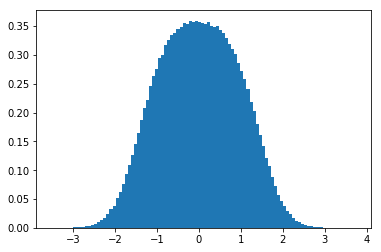

In [3]:
import numpy as np
from numpy.linalg import norm
from numpy.random import normal, uniform
import matplotlib.pyplot as plt
from time import clock

class Potential:
    """ Represents a potential function. """
    def __init__(self, potential="gaussian", dimension=1):
        self.dim = dimension
        self.name = potential
        # To add a potential, add it to the dictionary below and implement it/its gradient.
        self.function, self.gradient, self.gradient2, self.vector_lap_grad = {
            "gaussian":         (self.gaussian,         self.gaussian_grad,         None, None),
            "double_well":      (self.double_well,      self.double_well_grad,      self.double_well_grad2, self.double_well_vector_lap_grad),
            "Ginzburg_Landau":  (self.Ginzburg_Landau,  self.Ginzburg_Landau_grad,  None, None)
        }[potential]

        # Quantities to store in the Potential class, to avoid needless re-computation.
        self.inv_sigma = 1. / np.arange(1, dimension+1, dtype=float) # for Gaussian

    def gaussian(self, x):
        return 0.5 * np.dot(x, np.multiply(self.inv_sigma, x))

    def gaussian_grad(self, x):
        return np.multiply(self.inv_sigma, x)

    def double_well(self, x):
        normx = norm(x)
        return 0.25 * normx**4 - 0.5 * normx**2

    def double_well_grad(self, x):
        return (norm(x)**2 - 1) * x

    def double_well_grad2(self, x):
        mx = np.matrix(x)
        return (norm(x)**2 - 1) * np.identity(self.dim) + 2 * np.transpose(mx) * mx

    def double_well_vector_lap_grad(self, x):
        return 6*x

    def Ginzburg_Landau(self, x, tau=0.01, lamb=1, alpha=10):
        d_ = round(self.dim ** (1./3))
        x = np.reshape(x, (d_,d_,d_))
        nabla_tilde = sum( norm(np.roll(x, -1, axis=a) - x)**2 for a in [0,1,2] )
        return 0.5 * (1. - tau) * norm(x)**2 + \
               0.5 * tau * alpha * nabla_tilde + \
               0.25 * tau * lamb * np.sum(np.power(x, 4))

    def Ginzburg_Landau_grad(self, x, tau=2.0, lamb=0.5, alpha=0.1):
        d_ = round(self.dim ** (1./3))
        x = np.reshape(x, (d_,d_,d_))
        temp = sum( np.roll(x, sgn, axis=a) for sgn in [-1,1] for a in [0,1,2] )
        return ((1. - tau) * x + \
                tau * lamb * np.power(x, 3) + \
                tau * alpha * (6*x - temp)).flatten()

class Evaluator:
    """ Evaluates a set of Langevin algorithms on given potentials. """
    def __init__(self, potential="gaussian", dimension=1, N=10**2, burn_in=10**2, N_sim=5, x0=[0], step=0.01, timer=None):
        self.dim = dimension
        # To add an algorithm, add it to the dictionary below and implement it as a class method.
        self.algorithms = {
            "ULA":     self.ULA,
            "tULA":    self.tULA,
            "tULAc":   self.tULAc,
            "MALA":    self.MALA,
            "RWM":     self.RWM,
            "tMALA":   self.tMALA,
            "tMALAc":  self.tMALAc,
            "tHOLA":   self.tHOLA,
            "LM":      self.LM,
            "tLM":     self.tLM,
            "tLMc":    self.tLMc
        }
        self.N = N
        self.burn_in = burn_in
        self.N_sim = N_sim
        self.x0 = x0
        self.step = step
        self.timer = timer
        if timer:
            self.N = 10**10 # ~~practically infinity
            self.start_time = clock()
        self.potential = Potential(potential, dimension)
        # invoked by self.potential.funtion(parameters), self.potential.gradient(parameters)
    def ULA(self):
        x = np.array(self.x0)
        sample = np.zeros((self.dim, self.N + self.burn_in), dtype=float)
        sqrtstep = np.sqrt(2*self.step)

        for i in range(self.burn_in + self.N):
            if self.timer and clock() - self.start_time > self.timer:
                break
            sample[:,i]=x
            x += -self.step * self.potential.gradient(x) + sqrtstep * normal(size=self.dim)

        return sample #i+1 = no. of iterations

    def tULA(self, taming=(lambda g, step: g/(1. + step*norm(g)))):
        x = np.array(self.x0)
        sample = np.zeros((self.dim, self.N + self.burn_in), dtype=float)
        sqrtstep = np.sqrt(2*self.step)

        for i in range(self.burn_in + self.N):
            if self.timer and clock() - self.start_time > self.timer:
                break

            sample[:,i]=x
            x += -self.step * taming(self.potential.gradient(x), self.step) + sqrtstep * normal(size=self.dim)
        return sample

    def tULAc(self):
        # coordinate-wise taming function
        return self.tULA(lambda g, step: np.divide(g, 1. + step*np.absolute(g)))

    def MALA(self):
        acc = 0 # acceptance probability
        sample = np.zeros((self.dim, self.N + self.burn_in), dtype=float)
        x = np.array(self.x0)

        for i in range(self.burn_in + self.N):
            if self.timer and clock() - self.start_time > self.timer:
                break

            sample[:,i]=x
            U_x, grad_U_x = self.potential.function(x), self.potential.gradient(x)
            y = x - self.step * grad_U_x + np.sqrt(2 * self.step) * normal(size=self.dim)
            U_y, grad_U_y = self.potential.function(y), self.potential.gradient(y)

            logratio = -U_y + U_x + 1./(4*self.step) * (norm(y - x + self.step*grad_U_x)**2 \
                       -norm(x - y + self.step*grad_U_y)**2)
            if np.log(uniform(size = 1)) <= logratio:
                x = y
                if i >= self.burn_in:
                    acc += 1

        return sample

    def RWM(self):
        acc = 0 # acceptance probability
        sample = np.zeros((self.dim, self.N + self.burn_in), dtype=float)
        x = np.array(self.x0)

        for i in range(self.burn_in + self.N):
            if self.timer and clock() - self.start_time > self.timer:
                break

            sample[:,i]=x
            y = x + np.sqrt(2*self.step) * normal(self.dim)
            logratio = self.potential.function(x) - self.potential.function(y)
            if np.log(uniform(size = 1)) <= logratio:
                x = y
                if i >= self.burn_in:
                    acc += 1

        return sample


    def tMALA(self, taming=(lambda g, step: g/(1. + step*norm(g)))):
        acc = 0 # acceptance probability
        sample = np.zeros((self.dim, self.N + self.burn_in), dtype=float)
        x = np.array(self.x0)

        for i in range(self.burn_in + self.N):
            if self.timer and clock() - self.start_time > self.timer:
                break

            sample[:,i]=x
            U_x, grad_U_x = self.potential.function(x), self.potential.gradient(x)
            tamed_gUx = taming(grad_U_x, self.step)
            y = x - self.step * tamed_gUx + np.sqrt(2*self.step) * normal(size=self.dim)
            U_y, grad_U_y = self.potential.function(y), self.potential.gradient(y)
            tamed_gUy = taming(grad_U_y, self.step)

            logratio = -U_y + U_x + 1./(4*self.step) * (norm(y - x + self.step*tamed_gUx)**2 - norm(x - y + self.step*tamed_gUy)**2)
            if np.log(uniform(size = 1)) <= logratio:
                x = y
                if i >= self.burn_in:
                    acc += 1

        return sample

    def tMALAc(self):
        return self.tMALA(lambda g, step: np.divide(g, 1. + step * np.absolute(g)))

    def tHOLA(self):
        sample = np.zeros((self.dim, self.N + self.burn_in), dtype=float)
        x = np.array(self.x0)

        for i in range(self.burn_in + self.N):
            if self.timer and clock() - self.start_time > self.timer:
                break

            sample[:,i]=x
            norm_x = norm(x)
            grad_U = self.potential.gradient(x)
            norm_grad_U = norm(grad_U)
            grad_U_gamma = grad_U / (1 + (self.step * norm_grad_U)**1.5)**(2./3)
            grad2_U = self.potential.gradient2(x)
            norm_grad2_U = norm(grad2_U)
            grad2_U_gamma = grad2_U / (1 + self.step * norm_grad2_U)

            laplacian_grad_U = self.potential.vector_lap_grad(x)
            laplacian_grad_U_gamma = laplacian_grad_U / (1 + self.step**0.5 * norm_x * norm(laplacian_grad_U))

            grad2_U_grad_U_gamma = np.matmul(grad2_U, grad_U).A1 / (1 + self.step * norm_x * norm_grad2_U * norm_grad_U)

            x += -self.step * grad_U_gamma + 0.5 * self.step**2 * (grad2_U_grad_U_gamma - laplacian_grad_U_gamma) + \
                  np.sqrt(2*self.step) * normal(size=self.dim) - np.sqrt(2) * np.matmul(grad2_U_gamma, normal(size=self.dim)).A1 * np.sqrt(self.step**3/3)

        return sample

    def LM(self):
        x = np.array(self.x0)
        sample = np.zeros((self.dim, self.N + self.burn_in), dtype=float)
        sqrtstep = np.sqrt(0.5 * self.step)
        gaussian = normal(size=self.dim)

        for i in range(self.burn_in + self.N):
            if self.timer and clock() - self.start_time > self.timer:
                break

            sample[:,i]=x
            gaussian_plus1 = normal(size=self.dim)
            x += -self.step * self.potential.gradient(x) + sqrtstep * (gaussian + gaussian_plus1) * 0.5
            gaussian = gaussian_plus1
        return sample

    def tLM(self, taming=(lambda g, step: g/(1. + step * norm(g)))):
        x = np.array(self.x0)
        sample = np.zeros((self.dim, self.N + self.burn_in), dtype=float)
        sqrtstep = np.sqrt(0.5 * self.step)
        gaussian = normal(size=self.dim)

        for i in range(self.burn_in + self.N):
            if self.timer and clock() - self.start_time > self.timer:
                break

            sample[:,i]=x
            gaussian_plus1 = normal(size=self.dim)
            x += -self.step * taming(self.potential.gradient(x), self.step) + sqrtstep * (gaussian + gaussian_plus1) * 0.5
            gaussian = gaussian_plus1

        return sample

    def tLMc(self):
        return self.tLM(lambda g, step: np.divide(g, 1. + step * np.absolute(g)))

    def sampler(self, algorithm="ULA"):
        if self.timer:
            self.start_time = clock()
        return self.algorithms[algorithm]()

potential = 'double_well'
d = 2
N = 10**6
burn_in = 10**4
N_sim = 1
x0 = np.array([0] + [0]*(d-1), dtype=float)
step = 0.1

# TIMER MODE: number of seconds which we allow the algorithms to run
# To run normally without a timer, omit the last parameter
timer = 2.5

e = Evaluator(potential, dimension=d, N=N, burn_in=burn_in, N_sim=N_sim, x0=x0, step=step)


MALA_data = e.sampler("tULA")
#tULA_data = e.sampler("tULA")

# fig = plt.figure()
# plt.title("Trace" )
# plt.plot(ULA_data[0],ULA_data[1],'r')
# plt.plot(tULA_data[0],tULA_data[1],'g')
#
# from matplotlib import cm
# from scipy.stats import multivariate_normal as MVN
#
# """Plot heatmap of 2D MVN distribution """
# # Our 2-dimensional distribution will be over variables X and Y
# N = 600
# X = np.linspace(min(np.append(ULA_data[0], tULA_data[0])), max(np.append(ULA_data[0],tULA_data[0])), N)
# Y = np.linspace(min(np.append(ULA_data[1], tULA_data[1])), max(np.append(ULA_data[1],tULA_data[1])), N)
# X, Y = np.meshgrid(X, Y)
#
# # Mean vector and covariance matrix
# mu = np.array([0., 0])
# Sigma = np.diag(np.arange(1, 3, dtype=float))
#
# # Pack X and Y into a single 3-dimensional array
# pos = np.empty(X.shape + (2,))
# pos[:, :, 0] = X
# pos[:, :, 1] = Y
#
# F = MVN(mu, Sigma)
# Z = F.pdf(pos)
#
# ax = fig.gca()
# ax.contourf(X, Y, Z, zdir='z', levels=9, offset=-0.15, cmap=cm.hot, alpha=0.5)
# cset = plt.contour(X, Y, Z, cmap=cm.hot, alpha=0.5)
#
# plt.show()

for i in range(1,d):
    plt.hist(MALA_data[i,burn_in:-1], density=True, bins=100)
    plt.show()
